In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
from torch.utils.data import DataLoader

from decode_fish.funcs.output_trafo import model_output_to_df

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [4]:
exps = sorted(glob.glob('../fishcod/runs/ae1/dataloader.bs*'))
# fig = plot_tb_logs(exps, 'SL Losses/gmm_loss', 1)
fig = plot_tb_logs(exps, 'Inp. Metrics/eff_3d', 1)

KeyError: 'Key Inp. Metrics/eff_3d was not found in Reservoir'

In [18]:
def eval_perf(model, img, gt, cuda=True, shift=True, px_size=np.array([100.,100.,300.])):
    
    model.eval().cuda() if cuda else model.eval().cpu()
    with torch.no_grad():
        res_dict = model(img[None].cuda()) if cuda else model(img[None])
    res_dict['xyzi_mu'] = res_dict['xyzi_mu']
    pred_df = model_output_to_df(res_dict, 0.1, px_size=px_size)
    free_mem()
    
    pred = pred_df
    if shift:
        perf_df, matches, shift = matching(gt_df, pred, print_res=True)
        pred = shift_df(pred, shift)
    perf_df, matches, _ = matching(gt_df, pred)
    return pred

In [19]:
basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_1'
img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 200, 'cell3D', 'strong')
print(img.shape)

/groups/turaga/home/speisera/share_TUM/FishSIM/sim_1/mRNAlevel_200/cell3D/strong/w1_HelaKyoto_Gapdh_2597_p01_cy3__Cell_CP_14__cell3D__1.tif
torch.Size([1, 69, 318, 345])


In [20]:
gt_psf = load_tiff_image('/groups/turaga/home/speisera/share_TUM/FishSIM/PSF.tif')

In [89]:
# cfg_path = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/test/test_sub/train.yaml'
cfg_path = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/ae1/dataloader.bs:6/train.yaml'
cfg = OmegaConf.load(cfg_path)
model = load_model_state(cfg, 'model_ae.pkl')
psf, noise, micro = load_psf_micro_psf_noise(cfg)
psf.load_state_dict(torch.load(Path(cfg.output.save_dir)/'psf_ae.pkl'))

In [90]:
pred_df = eval_perf(model, img[:,:], gt_df, cuda=True, shift=True, px_size=np.array([100.,100.,300.]))
free_mem()

Recall: 0.996
Precision: 0.481
Jaccard: 47.959
RMSE_vol: 191.294
Eff_3d: -8.888
FN: 1.0 FP: 254.0
Shift: 0.81,-41.52,-180.49
Recall: 1.000
Precision: 0.483
Jaccard: 48.262
RMSE_vol: 43.588
Eff_3d: 43.859
FN: 0.0 FP: 253.0
Shift: 1.79,-0.50,-7.10


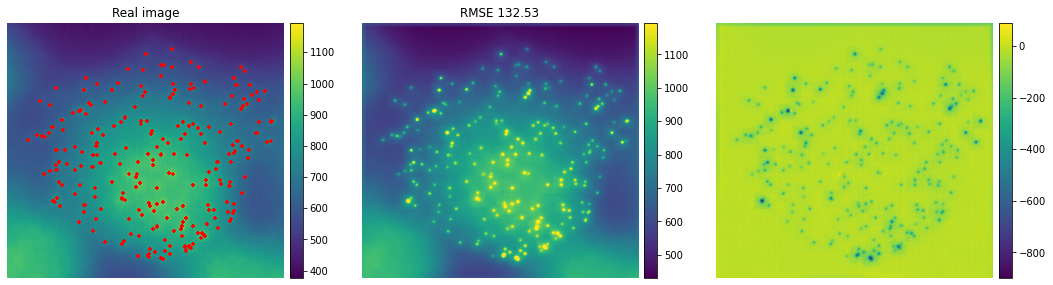

In [91]:
from decode_fish.funcs.output_trafo import *
with torch.no_grad():
    model.cuda()
    res_gt = model(img[None].cuda())
    locs_ae, x_os_ae, y_os_ae, z_os_ae, ints_ae, output_shape_ae = model_output_to_micro_input(res_gt, threshold=0.1)
    ae_img = micro(locs_ae, x_os_ae, y_os_ae, z_os_ae, ints_ae, output_shape_ae)
    pred_gt_df = model_output_to_df(res_gt, 0.1, px_size=np.array([100.,100.,300.]))
    free_mem()

    gt_fig = gt_plot(img, pred_gt_df, gt_df, np.array([100.,100.,300.]),ae_img[0]+res_gt['background'][0])
    plt.show()

In [57]:
pred = fq_nog_df
perf_df, matches, shift = matching(gt_df, pred, print_res=False)
pred = shift_df(pred, shift)
perf_df, matches, _ = matching(gt_df, pred)

Recall: 0.945
Precision: 0.987
Jaccard: 93.305
RMSE_vol: 37.757
Eff_3d: 79.970
FN: 13.0 FP: 3.0
Shift: -0.45,-0.90,-4.04


In [92]:
psf_sl, _, _ = load_psf_micro_psf_noise(cfg)
psf_sl.load_state_dict(torch.load(Path(cfg.output.save_dir)/'psf_sl.pkl'))

psf_ae, _, _ = load_psf_micro_psf_noise(cfg)
psf_ae.load_state_dict(torch.load(Path(cfg.output.save_dir)/'psf_ae.pkl'))

<All keys matched successfully>

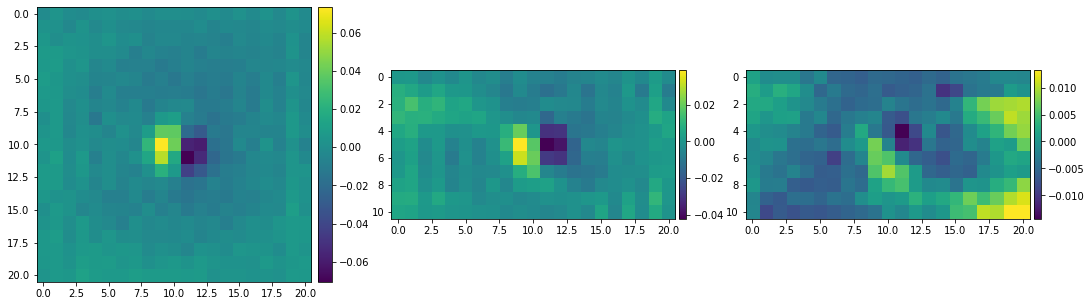

In [93]:
plot_3d_projections(psf_sl.psf_volume.detach().numpy()[0]-psf_ae.psf_volume.detach().numpy()[0])

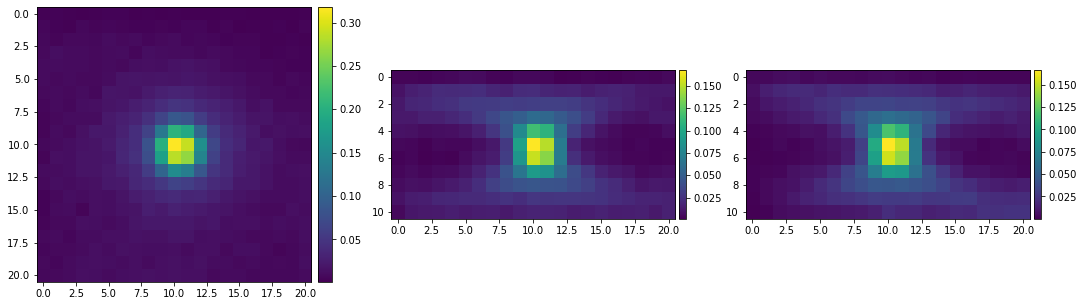

In [94]:
plot_3d_projections(psf_sl.psf_volume.detach().numpy()[0])

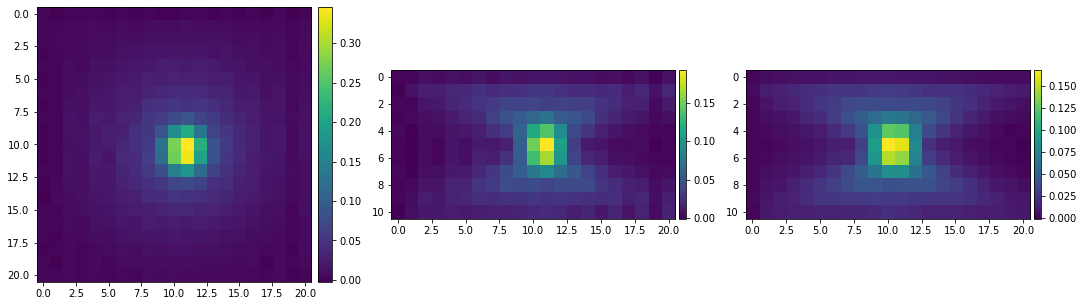

In [95]:
plot_3d_projections(psf_ae.psf_volume.detach().numpy()[0])

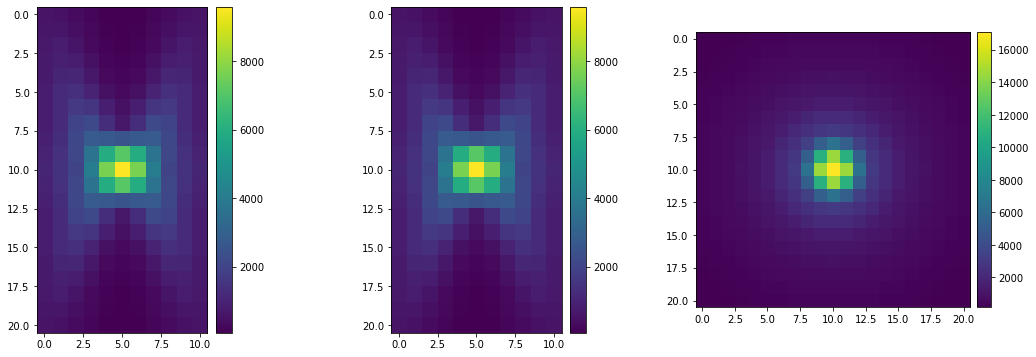

In [17]:
gt_psf = load_tiff_image('/groups/turaga/home/speisera/share_TUM/FishSIM/PSF.tif')
plot_3d_projections(gt_psf[0,::3,::3,::3].T)